This notebook uses cifar dataset to analyse best practices when training CNNs including learning rate scheduling. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os 
from tqdm import tqdm_notebook
import random, math

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from collections import OrderedDict

from clr import CyclicLR

In [3]:
path = "data/cifar10/"
use_gpu = torch.cuda.is_available()
batch_size=64

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.Scale(224),
        #transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Scale(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

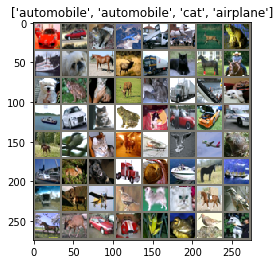

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914 ,  0.48216,  0.44653])
    std = np.array([0.24703,  0.24349,  0.26159])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs.narrow(0,0,64))

imshow(out, title=[class_names[x] for x in classes[0:4]])

In [8]:
inputs.size()

torch.Size([64, 3, 32, 32])

## Models

### Simple CNN

In [9]:
class simpleCnn(nn.Module):
    def __init__(self):
        super(simpleCnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### img size 224 CNN

In [10]:
class simpleCnnL(nn.Module):
    def __init__(self):
        super(simpleCnnL, self).__init__()
        #Stride 1 and padding 0 (defaults)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(4, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(4, 2)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.pool3 = nn.MaxPool2d(4, 2)
        self.conv4 = nn.Conv2d(32, 64, 5)
        self.pool4 = nn.MaxPool2d(4, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Resnet

In [11]:
class BasicBlock(nn.Module):

    def __init__(self, n_in, n_out, stride=1):
        super(BasicBlock, self).__init__()
        self.connection = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(n_in, n_out, 3, stride, 1, bias=False)),
            ('norm1', nn.BatchNorm2d(n_out)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(n_out, n_out, 3, 1, 1, bias=False)),
            ('norm2', nn.BatchNorm2d(n_out)),
        ]))
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(n_in, n_out, 1, stride, bias=False),
            nn.BatchNorm2d(n_out),
        )
        self.stride = stride

    def forward(self, x):
        mapping = self.connection(x)
        if self.stride != 1:
            x = self.downsample(x)
        return self.relu(mapping + x)


class ResidualBlock(nn.Module):

    def __init__(self, n_in, n_out, n_block, stride=1):
        super(ResidualBlock, self).__init__()
        self.blocks = nn.Sequential()
        self.blocks.add_module('block0', BasicBlock(n_in, n_out, stride))
        for i in range(n_block - 1):
            self.blocks.add_module('block{}'.format(i + 1), BasicBlock(n_out, n_out))

    def forward(self, x):
        return self.blocks(x)


class ResNetCifar10(nn.Module):

    def __init__(self, n_block=3):
        super(ResNetCifar10, self).__init__()
        ch = [16, 32, 64]
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, ch[0], 3, 1, 1, bias=False)),
            ('norm1', nn.BatchNorm2d(ch[0])),
            ('relu1', nn.ReLU(inplace=True)),
            ('resb1', ResidualBlock(ch[0], ch[0], n_block)),
            ('resb2', ResidualBlock(ch[0], ch[1], n_block, 2)),
            ('resb3', ResidualBlock(ch[1], ch[2], n_block, 2)),
            ('avgpl', nn.AvgPool2d(8)),
        ]))
        self.fc = nn.Linear(ch[2], 10)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x)

In [12]:
#Plotting loss decrease over iterations
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [13]:
def find(model, criterion, optimizer, data, scheduler, max_step=50):
    losses = []
    lrs = []
    iters = 1
    best_loss = 10
    for iters in tqdm_notebook(range(max_step)):  # loop over the dataset multiple times
        # get the inputs
        inputs, labels = next(iter(dataloaders['train']))

        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        scheduler.batch_step()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        lrs.append(scheduler.get_lr())
        iters += 1
        
        if loss.data[0] < best_loss:
            best_loss = loss.data[0]
        if loss.data[0] > best_loss*2:
            break

    return losses, lrs

In [14]:
def train(epochs, model, criterion, optimizer, dataloaders, clr=None, canneal=None, plot_every=100):
    plot_losses = []
    losses = []
    lrs = []
    plot_loss_total = 0 # Reset every plot_every
    lr = 0
    iters = 0
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                    
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    if clr != None:
                        clr.batch_step()
                    if canneal != None:
                        canneal.step()
                    plot_loss_total += loss.data[0]
                    loss.backward()
                    optimizer.step()
                    iters += 1
                    if iters % plot_every == 0:
                        losses.append(loss.data[0])
                        plot_loss_avg = plot_loss_total / plot_every
                        plot_losses.append(plot_loss_avg)
                        plot_loss_total = 0
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase=='train':
                train_loss = epoch_loss; train_acc = epoch_acc
                continue
            print('Train Loss: {:.4f} Train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f}'.format(
                train_loss, train_acc, epoch_loss, epoch_acc), end='\r', flush=True)
    return plot_losses

## Training

Preferred Optimization technique is SGD with momentum, cyclic learning rates and cosine annealing. [This](https://arxiv.org/abs/1705.08292) paper puts a strong case for moving away from adaptive optimization methods like Adam. Validating results were also found in practice with the above model. Below is a description of the most effective method. <br>
<b>Stochastic Gradient Descent</b> optimizer with [momentum](https://distill.pub/2017/momentum/) is used. Now, a natural difficulty is finding the most appropriate learning rate. <br>
An interesting solution to this is <b>[Cyclical Learning Rates](https://arxiv.org/abs/1506.01186)</b>. Simply put, it is about increasing the learning rate from an estimate of a minimum to an estimate of a maximum in a specified amount of iterations. The hope is that by recording the loss and the learning rate, the range of valid learning rates can be narrowed down. Furthermore, this narrowed down range of learning rates can be used in multiple cycles where the learning rate rise and falls. This is a great way to get out of local minimas. <br>
Another addition is <b>[cosine annealing](https://arxiv.org/pdf/1608.03983.pdf)</b> and warm restarts to squeeze a bit more out of the narrowed down learning rates. Cosine annealing will be reintroduced in a clever trick later. 

### Finding optimal learning rates
This can be acheived by training for a step size which is equavalent to a incremental linear rise from base_lr to max_lr. Losses and learning rates can be plotted to identify which learning rates give optimal results.

In [15]:
net = ResNetCifar10()
#net = simpleCnn()

In [16]:
if use_gpu: net.cuda()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.08, momentum=0.9)

In [18]:
def plot_lr_loss(losses, lrs):
    plt.ylabel("Loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(lrs, losses)
    plt.xscale('log')

HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

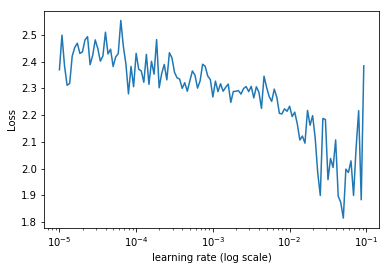

In [19]:
lrscheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=0.1, step_size=120, mode='finder', scale_mode='iterations')
losses, lrs = find(net, criterion, optimizer, dataloaders,
                       lrscheduler, 120)
plot_lr_loss(losses, lrs)

Best accuracy was observed with 8 epochs of cyclical learning rate and 2 with cosine annealing.

In [20]:
net = ResNetCifar10()
if use_gpu: net.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.08, momentum=0.9)

In [49]:
epochs = 8
canneal = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*len(dataloaders['train']), eta_min=0.005)
clr = CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size=5*len(dataloaders['train']))
plot_losses = train(epochs, net, criterion, optimizer, dataloaders, canneal=canneal, clr=None)

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

Train Loss: 0.1259 Train Acc: 0.9586 Val Loss: 0.4563 Val Acc: 0.8629


### Snapshot ensembling
[Snapshot Ensemble](https://arxiv.org/abs/1704.00109) is a method to obtain ensembles of multiple neural networks at no additional training cost. With cosine annealing we can let a single neural network converge into several local minima along its optimization path and save the model. 

In [51]:
import copy

In [52]:
m = 10
models = []
for x in range(m):
    model = copy.deepcopy(net) 
    epochs = 1
    canneal = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*len(dataloaders['train']), eta_min=0.005)
    _ = train(epochs, model, criterion, optimizer, dataloaders, canneal=canneal, clr=None)
    models.append(model)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.1149 Train Acc: 0.9629 Val Loss: 0.4607 Val Acc: 0.8631


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3204 Train Acc: 0.8851 Val Loss: 0.7028 Val Acc: 0.8052


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3182 Train Acc: 0.8847 Val Loss: 0.6916 Val Acc: 0.8092


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3183 Train Acc: 0.8872 Val Loss: 0.6876 Val Acc: 0.8084


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3212 Train Acc: 0.8842 Val Loss: 0.6777 Val Acc: 0.8114


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3186 Train Acc: 0.8857 Val Loss: 0.6982 Val Acc: 0.8087


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3172 Train Acc: 0.8855 Val Loss: 0.6839 Val Acc: 0.8112


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3228 Train Acc: 0.8831 Val Loss: 0.6901 Val Acc: 0.8102


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3190 Train Acc: 0.8857 Val Loss: 0.6738 Val Acc: 0.8132


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.3193 Train Acc: 0.8854 Val Loss: 0.6794 Val Acc: 0.8114


## Evaluation

In [53]:
def evaluate_model_ensemble(states, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    correct = 0
    total = 0
    outputsc = Variable(torch.zeros(64, 10))
    for i, data in enumerate(dataloaders['val']):
        if len(data[0])<64:
            break
        allpreds = Variable(torch.zeros(64, 10))
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        for x in range(10):
            #pdb.set_trace()
            outputs = states[x](inputs)
            outputsc += outputs.cpu()
            #print (outputs.size)
            #allpreds[:,x]=preds.unsqueeze(1)
        outputsc = torch.div(outputsc, 10)
        _, preds = torch.max(outputsc.data, 1)
        #allpreds = allpreds.data.numpy().astype(int)
        #cpreds = [np.bincount(x).argmax() for x in allpreds]
        total += labels.size(0)
        correct += (preds.numpy() == labels.cpu().data.numpy()).sum()
        if i == len(dataloaders['val'])-2:
            print('Accuracy of the network on test images: %d %%' % (
                100 * correct / total))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return


Accuracy of the network on test images: 81 %


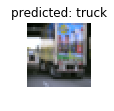

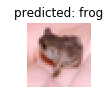

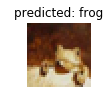

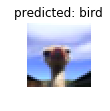

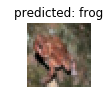

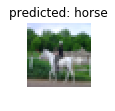

In [61]:
evaluate_model_ensemble(models)

In [38]:
def evaluate_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    correct = 0
    total = 0
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds.cpu().numpy() == labels.cpu().data.numpy()).sum()
        if i == len(dataloaders['val'])-1:
            print('Accuracy of the network on test images: %d %%' % (
                100 * correct / total))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return


Accuracy of the network on test images: 81 %


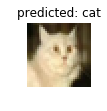

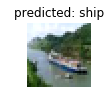

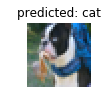

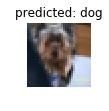

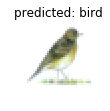

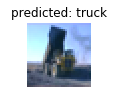

In [63]:
evaluate_modelf(models[7])